# General breakdown of the processing steps for embedding BPMN files:


## IMPORTANT: 
The current model uses an embedding created by 'paraphrase-multilingual-MiniLM-L12-v2' with an embedding dimension of 384.
Using any other sentence-transformer will result in unexpected behavior, so when using the kerasEmbedder use it toghether with the correct sentence-transformer.
If using it with mu-search, adjust the 'dims' parameter to the appropriate size.


## Motivation:
The goal is to create embeddings for BPMN files that can be used for search, similarity, and clustering tasks.  

The embeddings should be able to capture the semantics of the BPMN files, such that similar BPMN files have similar embeddings. The embeddings should be able to capture the structure of the BPMN files, such that BPMN files with similar structures have similar embeddings.  

Make semantic search possible: Given a query BPMN file, the system should be able to retrieve similar BPMN files based on the query of the user. User queries can be keywords, key phrases, or natural language queries. Example: "Geef mij alle BPMN diagrammen over het melden van klachten."  

## Design choices:
* Embedding models have a fixed input size, so we need to preprocess the BPMN files so it fits the input size or we need a way to handle large inputs by splitting them into smaller parts.
* Embedding models do not take the structure of the BPMN diagrams into account, so we need to find a way to encode the structure of the BPMN diagrams into the embeddings.
* We want to create a single embedding for the BPMN file that captures both the semantics and structure of the BPMN file.
* Semantics: The most important information in BPMN files is in the nodes and edges, so we need to extract the nodes and edges from the BPMN files. More specifically, we need to extract the labels of the nodes and edges and additional information. This comes down to 'name' and 'documentation' fields of the nodes and edges.
* To encode the structure of the BPMN diagrams, we can use graph embedding techniques such as Graph Neural Networks (GNNs) or Graph Convolutional Networks (GCNs).
* As these methods expect a graph as input, we need to convert the BPMN diagrams into a graph representation. A great library for this is NetworkX.
* To use the information of the nodes and edges, we need to convert them into numerical vectors. This can be done by using pre-trained embeddings or by training our own embeddings (see RoBERTa-model trained on Lokaal Beslist).
* To create a baseline, we can simply average the embeddings of the nodes and edges to create a single embedding for the BPMN file.
* To create a more advanced model, we can use a GNN or GCN using libraries such as Spektral or DGL.


## Similarity model specifics:
* The similarity model should be able to calculate the similarity between two BPMN files based on their embeddings.
* The similarity model should be able to rank the BPMN files based on their similarity to a query BPMN file.
* The similarity model should be able to handle large datasets of BPMN files efficiently.


## Similarity model design:
* The similarity model can be a simple cosine similarity model that calculates the cosine similarity between two embeddings.
* The embedding only needs to be calculated once for each BPMN file and stored within the triplestore.
* Integration with Elasticsearch or other search engines can be used to efficiently retrieve the most similar BPMN files based on the query (BPMN embedding of the source BPMN).


## Current approach:
* Convert BPMN files to graph representations using NetworkX.
* Create embeddings for the nodes and edges using pre-trained embeddings.
* Use the embeddings as features for a GNN or GCN model to create a single graph embedding for a BPMN file using Spektral.


## Shortcomings:
* Lack of BPMN files to train our own embeddings and validate the model (similar to search).
* Lack of real user queries to validate the model. For this model, this is the accuracy of the model in retrieving similar BPMN files based on a user query. * How well are the suggestions of the model aligned with the expectations of the user?
* Future steps or what should be done next when enough data is available:
* Start gathering information: Gather BPMN files, user interactions with the recommendations, and feedback on the recommendations. Requirements (same as search): It's important to have a large enough dataset of BPMN files with enough variety to train the embeddings and validate the model. E.g., if all the data is about the same process (handling of disputes), the model will not be able to generalize to other processes. It's hard to quantify how much data is needed, but a few hundred BPMN files should be a good start.
* Train our own text embeddings for the nodes and edges using a model such as RoBERTa trained on BPMN files.
* Validate the current Spektral model using the new data.
* Change the architecture of the GNN or GCN model if needed (possibly add more layers, change the activation functions, etc.).
* Merge the two models: There is a lot of overlap between the two models, so it might be possible to merge them into a single model and use the graph embeddings for both tasks.


## Suggestions:
* Store all search results from mu-search (anonymously) to use as training data, so all types of queries are automatically covered. E.g., store each search request to BPMN-search to gain insights into how users typically structure their queries.
* Store the interactions with the search results to gain insights into how users interact with the search results. E.g., store the retrieved BPMN search results and the interactions. This can be used to train a model to rank the search results based on the interactions of the users.

# loading data

In [3]:
import os
import json
from tqdm import tqdm
from library.BPMNGraphEmbedder import BPMNGraphEmbedder
from library.BPMNGraph import BPMNGraph



# Start by loading in the BPMN files using the BPMNGraph class and the BPMNGraphEmbedderKeras class, for converting it to a networkx graph and embedding it respectively.
# Then, load in the search dataset and create samples from it. Each sample should contain the query, the query embedding, the BPMN graph, and the label.


def process_bpmn_file(graphEmbedder, bpmn_file_path):
    bpmn_graph = BPMNGraph(bpmn_file_path)
    graphEmbedder.process_graph(bpmn_graph.network, logging=False)
    return bpmn_graph

def process_bpmn_files(graphEmbedder, files):
    all_bpmns = {}

    # Process each BPMN file in the list
    for bpmn_file in tqdm(files):
        # Check if the file has .bpmn extension
        if bpmn_file.endswith('.bpmn'):
            bpmn_graph = process_bpmn_file(graphEmbedder, bpmn_file)
            all_bpmns[bpmn_file.split("\\")[-1]] = bpmn_graph

    return all_bpmns

def process_bpmn_files_in_folders(folders):
    graphEmbedder = BPMNGraphEmbedder()
    sentence_embedder = graphEmbedder.get_embedding_model()
    all_bpmns = {}

    for folder in folders:
        files = os.listdir(folder)
        folder_bpmns = process_bpmn_files(graphEmbedder, files)
        all_bpmns.update(folder_bpmns)

    return all_bpmns, sentence_embedder

def create_samples(comparisons, all_bpmns):
    samples = []

    # example of a comparison: {'source_bpmn_id': '01_-_Vorbereitung_Warenversand_e29ad857608345f4a3c8ee5eefc44129.bpmn', 'source_class': '01-Dispatch-of-goods', 'target_bpmn_id': '01_-_Vorbereitung_Warenversand_e29ad857608345f4a3c8ee5eefc44129.bpmn', 'target_class': '01-Dispatch-of-goods', 'similarity': 1.0, 'normalized_similarity': 1.0}
    for comparing in comparisons:
        source_bpmn_id = comparing.get("source_bpmn_id")
        target_bpmn_id = comparing.get("target_bpmn_id")
        similarity = comparing.get("similarity")

        source_bpmn = all_bpmns.get(source_bpmn_id)
        target_bpmn = all_bpmns.get(target_bpmn_id)

        if source_bpmn is None:
            print("BPMN not found: ", source_bpmn_id)
            continue

        if target_bpmn is None:
            print("BPMN not found: ", target_bpmn_id)
            continue
        
        samples.append({
            "query": source_bpmn,
            "target": target_bpmn,
            "score": similarity,
            "query_class": comparing.get("source_class"),
            "target_class": comparing.get("target_class")
        })

    return samples

folders = [
    "data\\camunda\\German\\01-Vorbereitung-des-Warenversands\\02-Ergebnisse\\",
    "data\\camunda\\German\\02-Regressnahme\\02-Ergebnisse\\",
    "data\\camunda\\German\\03-Schufascoring\\02-Ergebnisse\\",
    "data\\camunda\\German\\04-Selbstbedienungsrestaurant\\02-Ergebnisse\\",
    "data\\camunda\\English\\01-Dispatch-of-goods\\02-Results\\",
    "data\\camunda\\English\\02-Recourse\\02-Results\\",
    "data\\camunda\\English\\03-Credit-scoring\\02-Results\\",
    "data\\camunda\\English\\04-Self-service-restaurant\\02-Results\\",
]

#all_bpmns, sentence_embedder = process_bpmn_files_in_folders(folders)


In [6]:


import importlib
from library.BPMNGraphEmbedder import BPMNGraphEmbedder


location = "data\\camunda"
all_bpmns = process_bpmn_files(BPMNGraphEmbedder(),[location+"\\"+file_name for file_name in files] )
#all_bpmns_testing = process_bpmn_files(BPMNGraphEmbedder(),[location+"\\"+file_name for file_name in files[:50]] )


Loading sentence model: paraphrase-multilingual-MiniLM-L12-v2
Loading keybert model: paraphrase-multilingual-MiniLM-L12-v2


100%|██████████| 597/597 [18:38<00:00,  1.87s/it]


In [4]:
def read_jsonl(file_path, same_class_check=True):
    data = []
    unique_bpmn_ids = set()

    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line)

            if entry["source_bpmn_id"] not in unique_bpmn_ids:
                unique_bpmn_ids.add("\\".join(entry["source_bpmn_id"].split("\\")[-4:]))
            if entry["target_bpmn_id"] not in unique_bpmn_ids:
                unique_bpmn_ids.add("\\".join(entry["target_bpmn_id"].split("\\")[-4:]))

            if same_class_check:
                similarity = entry["edit_distance"] if entry["source_class"] == entry["target_class"] else 0.0
                normalized_similarity = entry["normalized_edit_distance"] if entry["source_class"] == entry["target_class"] else 0.0
            else:
                similarity = entry["edit_distance"]
                normalized_similarity = entry["normalized_edit_distance"]

            data.append({
                'source_bpmn_id': entry["source_bpmn_id"].split("\\")[-1],
                'source_class': entry["source_class"],
                'target_bpmn_id':entry["target_bpmn_id"].split("\\")[-1],
                'target_class': entry["target_class"],
                "similarity": similarity,
                "normalized_similarity": normalized_similarity
            })

    sorted_data = sorted(data, key=lambda x: x["similarity"], reverse=True)
    return sorted_data, list(unique_bpmn_ids)

#loading the dataset with the edit distance between the BPMN files

compare_file_path = "datasets\\camunda_edit_distance_dataset_01.jsonl"
data, files = read_jsonl(compare_file_path, same_class_check=False)
print(len(data),data[0])

50688 {'source_bpmn_id': '01_-_Vorbereitung_Warenversand_e29ad857608345f4a3c8ee5eefc44129.bpmn', 'source_class': '01-Dispatch-of-goods', 'target_bpmn_id': '01_-_Vorbereitung_Warenversand_e29ad857608345f4a3c8ee5eefc44129.bpmn', 'target_class': '01-Dispatch-of-goods', 'similarity': 1.0, 'normalized_similarity': 1.0}


In [7]:
samples = create_samples(data, all_bpmns)

import random

# display 5 random samples
random_samples = random.sample(samples, 5)
for sample in random_samples:
    print("\n-------------------------Sample:")
    print(sample["query_class"])
    print(sample["target_class"])
    print("---")
    print(sample["query"].file_path)
    print(sample["target"].file_path)
    print("---")
    print(sample["score"])


-------------------------Sample:
04-Self-service-restaurant
02-Recourse
---
data\camunda\German\04-Selbstbedienungsrestaurant\02-Ergebnisse\sb_res_007a6696804a4a54ad3ef642a3c4448d.bpmn
data\camunda\English\02-Recourse\02-Results\Ex_3_906bd7c47cfb4257ac43aa297c2da4cf.bpmn
---
0.3558718861209964

-------------------------Sample:
01-Dispatch-of-goods
04-Self-service-restaurant
---
data\camunda\German\01-Vorbereitung-des-Warenversands\02-Ergebnisse\Ueb_1_ae84ec3090aa4980a8dac59e4d557b47.bpmn
data\camunda\English\04-Self-service-restaurant\02-Results\sb_res_11ca13d016034e3e85f18fb4c0655006.bpmn
---
0.34519572953736655

-------------------------Sample:
04-Self-service-restaurant
03-Credit-scoring
---
data\camunda\German\04-Selbstbedienungsrestaurant\02-Ergebnisse\sb_res_04729f33ec3748bfbcd4a8fb2ace91e5.bpmn
data\camunda\German\03-Schufascoring\02-Ergebnisse\Schufascoring_0e13073c16054adf8e97d8a4bd46fa61.bpmn
---
0.2704626334519573

-------------------------Sample:
01-Dispatch-of-goods
04-Se

# Analyse distribution of samples overall and within each class

In [8]:
# Initialize counters
total_positive = 0
total_negative = 0
class_counts = {}
same_class_positive = 0
same_class_negative = 0
diff_class_positive = 0
diff_class_negative = 0


similarity_threshold = 0.5

for sample in samples:
    # Count positive and negative samples
    if sample["score"] > similarity_threshold:
        total_positive += 1
        if sample["query_class"] == sample["target_class"]:
            same_class_positive += 1
        else:
            diff_class_positive += 1
    else:
        total_negative += 1
        if sample["query_class"] == sample["target_class"]:
            same_class_negative += 1
        else:
            diff_class_negative += 1

    # Count samples per class
    if sample["query_class"] not in class_counts:
        class_counts[sample["query_class"]] = {"positive": 0, "negative": 0}
    if sample["score"] > similarity_threshold:
        class_counts[sample["query_class"]]["positive"] += 1
    else:
        class_counts[sample["query_class"]]["negative"] += 1

print("Total positive samples: ", total_positive)
print("Total negative samples: ", total_negative)
print("Same class positive samples: ", same_class_positive)
print("Same class negative samples: ", same_class_negative)
print("Different class positive samples: ", diff_class_positive)
print("Different class negative samples: ", diff_class_negative)
print("Samples per class: ", class_counts)

Total positive samples:  29097
Total negative samples:  21591
Same class positive samples:  11409
Same class negative samples:  1410
Different class positive samples:  17688
Different class negative samples:  20181
Samples per class:  {'01-Dispatch-of-goods': {'positive': 9735, 'negative': 4885}, '02-Recourse': {'positive': 8769, 'negative': 3859}, '03-Credit-scoring': {'positive': 7145, 'negative': 4136}, '04-Self-service-restaurant': {'positive': 3448, 'negative': 8711}}


# Baseline averaging model

In [9]:
import numpy as np

from sklearn.utils import resample

similarity_threshold = 0.5
similarity_threshold_baseline = 0.7

# Separate positive and negative samples
positive_samples = [sample for sample in samples if sample["score"] > similarity_threshold]
negative_samples = [sample for sample in samples if sample["score"] <= similarity_threshold]


# Balance the samples
if len(positive_samples) > len(negative_samples):
    # Undersample the positive samples
    positive_samples = resample(positive_samples, replace=False, n_samples=len(negative_samples), random_state=42)
else:
    # Oversample the negative samples
    negative_samples = resample(negative_samples, replace=True, n_samples=len(positive_samples), random_state=42)

# Combine the balanced samples
balanced_samples = positive_samples + negative_samples

TP = FP = TN = FN = 0

samples_with_scores_and_diffs = []

for sample in balanced_samples:
    query_embedding = sample["query"].get_graph().get("embedding")
    target_embedding = sample["target"].get_graph().get("embedding")

    # calculate the cosine similarity between the two embeddings and threshold it if both are not None
    if query_embedding is not None and target_embedding is not None:
        similarity = np.dot(query_embedding, target_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(target_embedding))
        prediction = similarity > similarity_threshold_baseline
        actual = sample["score"] > similarity_threshold

        # Calculate the difference between the score and the actual value
        #print(similarity, sample["score"], similarity - sample["score"])
        diff = abs(similarity - sample["score"])

        #print("same_file:", sample["query"].file_path == sample["target"].file_path, "same_class:", sample["query_class"] == sample["target_class"],
         #      "actual: ", sample["score"], "prediction: ", similarity, "diff: ", diff)

        # Add the sample, similarity score, and difference to the list
        samples_with_scores_and_diffs.append((sample, similarity, diff))
        
        if prediction and actual:
            TP += 1
        elif prediction and not actual:
            FP += 1
        elif not prediction and actual:
            FN += 1
        else:
            TN += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * precision * recall / (precision + recall)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

# Calculate the number of positive and negative samples
positive_samples = TP + FN
negative_samples = TN + FP

# Calculate the ratio of positive to negative samples
positive_negative_ratio = positive_samples / negative_samples

print("Positive samples: ", positive_samples)
print("Negative samples: ", negative_samples)
print("Ratio of positive to negative samples: ", positive_negative_ratio)

# Calculate the total number of samples
total_samples = positive_samples + negative_samples

# Calculate the percentage of positive and negative samples
positive_percentage = (positive_samples / total_samples) * 100
negative_percentage = (negative_samples / total_samples) * 100

print("Positive samples: {:.2f}%".format(positive_percentage))
print("Negative samples: {:.2f}%".format(negative_percentage))

# Sort the list by the absolute difference, in descending order
samples_with_scores_and_diffs.sort(key=lambda x: x[2], reverse=True)

Precision:  0.6527429805615551
Recall:  0.6998749478949562
F1 Score:  0.6754878076037639
Positive samples:  21591
Negative samples:  21591
Ratio of positive to negative samples:  1.0
Positive samples: 50.00%
Negative samples: 50.00%


In [10]:
different_class_samples = [sample for sample in samples_with_scores_and_diffs if sample[0]["query_class"] != sample[0]["target_class"] and sample[-2] > 0.6]
print("Different class samples: ", len(different_class_samples))

Different class samples:  23234



-------------------------Sample:
02-Recourse
01-Dispatch-of-goods
---
Similarity:  0.86086524
Score:  0.15658362989323849
Difference:  0.7042816054354358


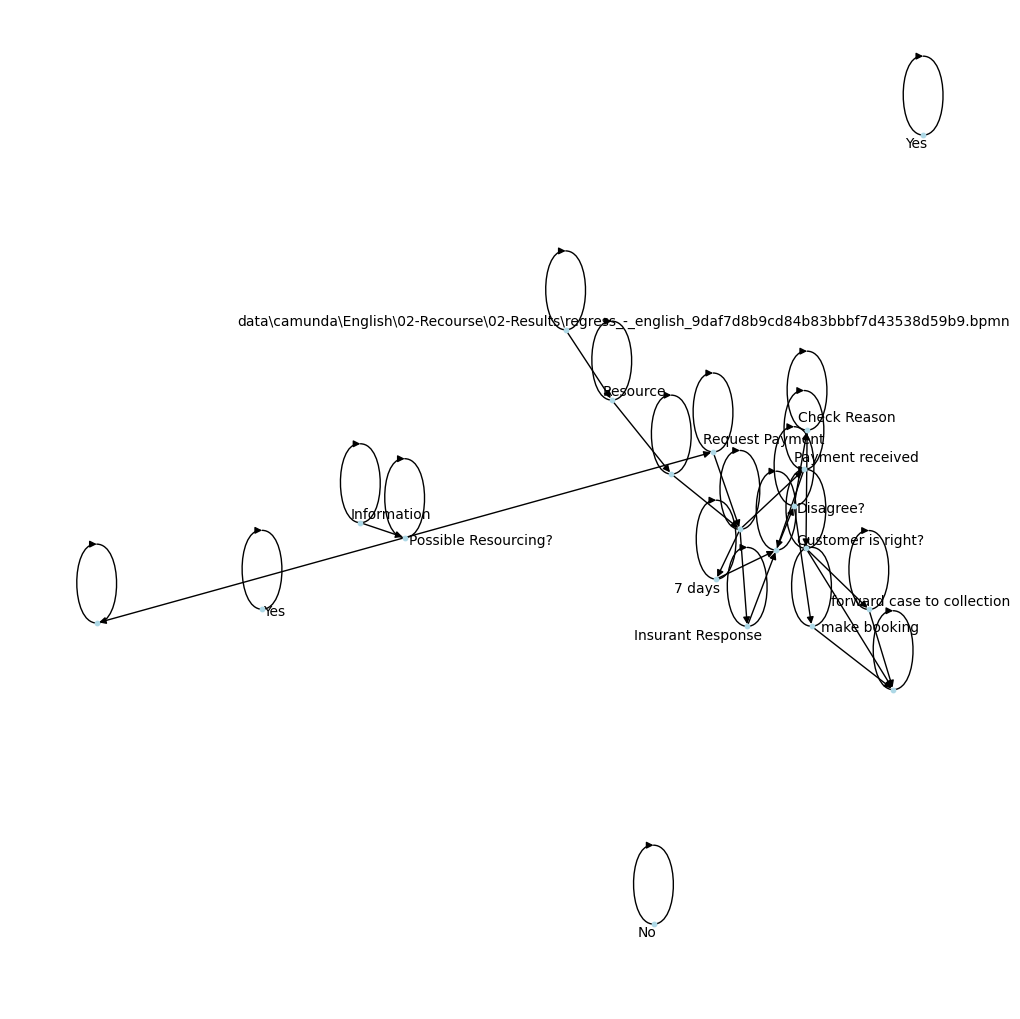

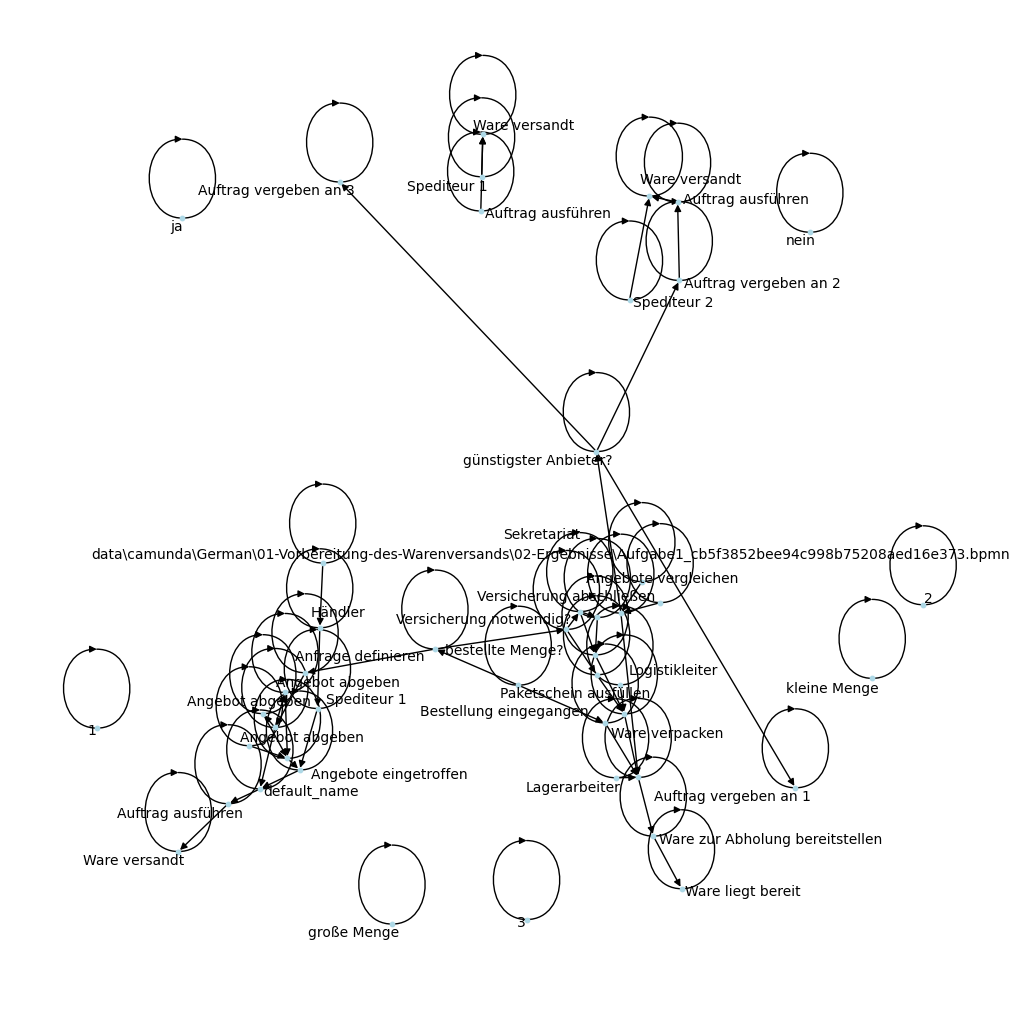

In [187]:
def print_difference(index, same_class_samples):
    sample = same_class_samples[index]
    print("\n-------------------------Sample:")
    print(sample[0]["query_class"])
    print(sample[0]["target_class"])
    print("---")
    print("Similarity: ", sample[1])
    print("Score: ", sample[0]["score"])
    print("Difference: ", sample[2])
    sample[0]["query"].draw_graph()
    sample[0]["target"].draw_graph()

print_difference(0, different_class_samples)

# Creating a Spektral dataset for the training samples

In [14]:
from spektral.data import Graph, Dataset, Loader, BatchLoader
from spektral.data.utils import get_spec, collate_labels_batch, sp_matrices_to_sp_tensors, to_batch, pad_jagged_array

import tensorflow as tf
import networkx as nx
import numpy as np

class BpmmComparingSpektralLoader(Loader):
    def __init__(self, dataset, mask=False, batch_size=1, epochs=None, shuffle=True, node_level=False):
        self.mask = mask
        self.node_level = node_level
        self.signature = dataset.signature
        super().__init__(dataset, batch_size=batch_size, epochs=epochs, shuffle=shuffle)

    def numpy(self, graph):
        # Return tuple of non-None elements
        return tuple(ret for ret in [graph.a_x, graph.a_a, graph.b_x, graph.b_a, graph.y] if ret is not None)
    
    def to_batch(self, a_x_list=None, a_a_list=None, b_x_list=None, b_a_list=None, mask=False):
        if a_a_list is None and a_x_list is None and b_a_list is None and b_x_list is None:
            raise ValueError("Need at least a_x_list or a_a_list or b_x_list or b_a_list")
    
        n_max = max([x.shape[0] for x in (a_x_list if a_x_list is not None else a_a_list)] +
                    [x.shape[0] for x in (b_x_list if b_x_list is not None else b_a_list)])
    
        # Node features for graph A
        a_x_out = None
        if a_x_list is not None:
            if mask:
                a_x_list = [np.concatenate((x, np.ones((x.shape[0], 1))), -1) for x in a_x_list]
            a_x_out = pad_jagged_array(a_x_list, (n_max, -1))
    
        # Adjacency matrix for graph A
        a_a_out = None
        if a_a_list is not None:
            if hasattr(a_a_list[0], "toarray"):  # Convert sparse to dense
                a_a_list = [a.toarray() for a in a_a_list]
            a_a_out = pad_jagged_array(a_a_list, (n_max, n_max))
    
        # Node features for graph B
        b_x_out = None
        if b_x_list is not None:
            if mask:
                b_x_list = [np.concatenate((x, np.ones((x.shape[0], 1))), -1) for x in b_x_list]
            b_x_out = pad_jagged_array(b_x_list, (n_max, -1))
    
        # Adjacency matrix for graph B
        b_a_out = None
        if b_a_list is not None:
            if hasattr(b_a_list[0], "toarray"):  # Convert sparse to dense
                b_a_list = [b.toarray() for b in b_a_list]
            b_a_out = pad_jagged_array(b_a_list, (n_max, n_max))
    
        return tuple(out for out in [a_x_out, a_a_out, b_x_out, b_a_out] if out is not None)

    def collate(self, batch):
        # Prepare output and keys
   
        output = [list(elem) for elem in zip(*[self.numpy(g) for g in batch])]
        keys = [k + "_list" for k in self.dataset.signature.keys()]
        packed = dict(zip(keys, output))

        # Process labels
        y = packed.pop("y_list", None)


        if y is not None:
            y = collate_labels_batch(y, node_level=self.node_level)


        # Print the length of output
        output = self.to_batch(**packed, mask=self.mask)

        # Convert sparse matrices to tensors
        A_X, A_A, B_X, B_A = output
        output = sp_matrices_to_sp_tensors((A_X, A_A, B_X, B_A))
        
        # Return output
        if len(output) == 1:
            output = output[0]
        if y is None:
            return output
        else:
            return output, y

class BPMNGraphProcessor:
 
    def get_node_features(self, bpmn_graph):
        # Get node features
        x = [node.get("embedding", np.zeros(384)).reshape(-1) for _, node in bpmn_graph.network.nodes(data=True)]
        return np.stack(x)

    def get_adjacency_matrix(self, bpmn_graph):
        # Get adjacency matrix
        return nx.adjacency_matrix(bpmn_graph.network).tocoo()

class BPMNGraphDataset(Dataset):
    def __init__(self, samples, **kwargs):
        self.samples = samples
        self.embedding_dims = 384
        self.processor = BPMNGraphProcessor()
        super().__init__(**kwargs)

    def process_graph(self, bpmn_graph):
        # Add self loop
        for node in bpmn_graph.network.nodes():
            bpmn_graph.network.add_edge(node, node)

        # Get adjacency matrix and node features
        a = self.processor.get_adjacency_matrix(bpmn_graph)
        x = self.processor.get_node_features(bpmn_graph)

        return a, x

    def read(self):
        return [self.create_graph(sample) for sample in self.samples if self.valid_sample(sample)]

    def valid_sample(self, sample):
        bpmn_graph_a = sample["query"]
        bpmn_graph_b = sample["target"]

        return all(len(bpmn_graph.get_nodes()) > 0 and len(bpmn_graph.get_edges()) > 0 for bpmn_graph in [bpmn_graph_a, bpmn_graph_b])

    def create_graph(self, sample):
        bpmn_graph_a = sample["query"]
        bpmn_graph_b = sample["target"]

        a_a, a_x = self.process_graph(bpmn_graph_a)
        b_a, b_x = self.process_graph(bpmn_graph_b)

        # Get class labels (convert boolean to int)
        if "score" in sample:
            y = float(sample["score"])
            return Graph(a_x=a_x, a_a=a_a, b_x=b_x, b_a=b_a, y=y)
        else:
            return Graph(a_x=a_x, a_a=a_a, b_x=b_x, b_a=b_a)
    
    @property
    def signature(self):
        """
        This property computes the signature of the dataset, which can be
        passed to `spektral.data.utils.to_tf_signature(signature)` to compute
        the TensorFlow signature. You can safely ignore this property unless
        you are creating a custom `Loader`.

        A signature consist of the TensorFlow TypeSpec, shape, and dtype of
        all characteristic matrices of the graphs in the Dataset. This is
        returned as a dictionary of dictionaries, with keys `x`, `a`, `e`, and
        `y` for the four main data matrices.

        Each sub-dictionary will have keys `spec`, `shape` and `dtype`.
        """
        if len(self.graphs) == 0:
            return None
        signature = {}
        graph = self.graphs[0]  # This is always non-empty
        if graph.a_x is not None:
            signature["a_x"] = dict()
            signature["a_x"]["spec"] = get_spec(graph.a_x)
            signature["a_x"]["shape"] = (None, self.embedding_dims)
            signature["a_x"]["dtype"] = tf.as_dtype(graph.a_x.dtype)
        if graph.a_a is not None:
            signature["a_a"] = dict()
            signature["a_a"]["spec"] = get_spec(graph.a_a)
            signature["a_a"]["shape"] = (None, None)
            signature["a_a"]["dtype"] = tf.as_dtype(graph.a_a.dtype)
        if graph.b_x is not None:
            signature["b_x"] = dict()
            signature["b_x"]["spec"] = get_spec(graph.b_x)
            signature["b_x"]["shape"] = (None, self.embedding_dims)
            signature["b_x"]["dtype"] = tf.as_dtype(graph.b_x.dtype)
        if graph.b_a is not None:
            signature["b_a"] = dict()
            signature["b_a"]["spec"] = get_spec(graph.b_a)
            signature["b_a"]["shape"] = (None, None)
            signature["b_a"]["dtype"] = tf.as_dtype(graph.b_a.dtype)
        if graph.y is not None:
            signature["y"] = dict()
            signature["y"]["spec"] = get_spec(graph.y)
            signature["y"]["shape"] = (self.n_labels,)
            signature["y"]["dtype"] = tf.as_dtype(np.array(graph.y).dtype)
        return signature
    
dataset = BPMNGraphDataset(balanced_samples)

# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

c:\Users\StefaanVercoutere\OneDrive - Sirus NV\OPH\gnn-citations\.conda\Lib\site-packages\spektral\data\dataset.py:120: UserWarning: The graphs in this dataset have no adjacency matrix. Is this intentional?
  warnings.warn(


In [15]:
len(dataset_tr), len(dataset_te)

(38734, 4304)

# Design the model using the Spektral library and keras

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Dot, Lambda, Concatenate, Dense
import tensorflow.keras.backend as K
from spektral.layers import GCNConv, GlobalAvgPool, GlobalAttentionPool

def create_gcn_layers(embedding_dims):
    # Define the shared GCN layers
    graph_conv = GCNConv(embedding_dims, activation='relu', name='graph_conv')
    dropout = Dropout(0.2, name='dropout')
    graph_conv_2 = GCNConv(embedding_dims, activation='relu', name='graph_conv_2')
    dropout_2 = Dropout(0.2, name='dropout_2')
    graph_conv_3 = GCNConv(embedding_dims, activation='relu', name='graph_conv_3')
    global_pool = GlobalAttentionPool(embedding_dims,name='global_pool')
    #global_pool = GlobalAvgPool(name='global_pool')

    return graph_conv, dropout, graph_conv_2, dropout_2, graph_conv_3, global_pool

def create_graph_model(X_in, A_in, graph_layers):
    graph_conv, dropout, graph_conv_2, dropout_2, graph_conv_3, global_pool = graph_layers

    # Pass graph through the shared layers
    graph_conv_out = graph_conv([X_in, A_in])
    dropout_out = dropout(graph_conv_out)
    graph_conv_2_out = graph_conv_2([dropout_out, A_in])
    dropout_2_out = dropout_2(graph_conv_2_out)
    graph_conv_3_out = graph_conv_3([dropout_2_out, A_in])
    graph_embedding = global_pool(graph_conv_3_out)

    return graph_embedding

def create_models(n_features, embedding_dims):
    # Define the inputs for graph A
    A_X_in = Input(shape=(None, n_features), name='A_Node_features')
    A_A_in = Input((None, ), sparse=True, name='A_Adjacency_matrix')

    # Define the inputs for graph B
    B_X_in = Input(shape=(None, n_features), name='B_Node_features')
    B_A_in = Input((None, ), sparse=True, name='B_Adjacency_matrix')

    # Create the GCN layers
    graph_layers = create_gcn_layers(embedding_dims)

    # Create the graph embeddings
    A_graph_embedding = create_graph_model(A_X_in, A_A_in, graph_layers)
    B_graph_embedding = create_graph_model(B_X_in, B_A_in, graph_layers)


    # concatenate the two embeddings
    concatenated = Concatenate(name='concatenated')([A_graph_embedding, B_graph_embedding])
    dense_layer = Dense(64, activation='relu')(concatenated)
    dense_layer = Dropout(0.2, name='dropout_conc')(dense_layer)
    dense_output = Dense(1, activation='sigmoid', name='output')(dense_layer)


    # Perform dot product between the two graph embeddings
    dot_product = Dot(axes=1, normalize=True, name='dot_product')([A_graph_embedding, B_graph_embedding])
    
    # Create the main model
    model = Model(inputs=[A_X_in, A_A_in, B_X_in, B_A_in], outputs=dense_output, name='my_model')

    # Create the embedding model
    embedding_model = Model(inputs=[A_X_in, A_A_in], outputs=A_graph_embedding, name='embedding_model')

    return model, embedding_model

# Create the model
model, embedding_model = create_models(n_features=384, embedding_dims=384)
model.summary()

Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 A_Node_features (InputLaye  [(None, None, 384)]          0         []                            
 r)                                                                                               
                                                                                                  
 A_Adjacency_matrix (InputL  [(None, None)]               0         []                            
 ayer)                                                                                            
                                                                                                  
 B_Node_features (InputLaye  [(None, None, 384)]          0         []                            
 r)                                                                                        

In [249]:
import matplotlib.pyplot as plt

def train_model(model, dataset, batch_size=32, epochs=10):
    """
    Trains the model on the given dataset.

    Parameters:
    model (Model): The model to train.
    dataset (Dataset): The dataset to train the model on.
    batch_size (int): The batch size to use for training.
    epochs (int): The number of epochs to train the model for.

    Returns:
    History: A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs.
    """
    try:
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.metrics import Precision, Recall, AUC
        
        # Create the model
        model, embedding_model = create_models(n_features=384, embedding_dims=384)
        
        # Compile the model with additional metrics
        model.compile(optimizer=Adam(), 
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall(), AUC()])
        
        # Create a loader
        loader = BpmmComparingSpektralLoader(dataset, batch_size=batch_size, shuffle=True)

        # Log the shapes of the inputs and targets
        batch = next(loader.load())
        inputs, y = batch
        A_X, A_A, B_X, B_A = inputs
        
        print(f"A shape:( {A_X.shape}, {A_A.shape}), B shape:( {B_X.shape}, {B_A.shape}), y shape: {y.shape}")

        # Train the model
        history = model.fit(loader.load(), steps_per_epoch=loader.steps_per_epoch, epochs=epochs)

        return model, embedding_model, history
    except Exception as e:
        print(f"An error occurred: {e}")

    return None, None, None

def evaluate_model(model, dataset, batch_size=32):
    """
    Evaluates the model on the given dataset.

    Parameters:
    model (Model): The model to evaluate.
    dataset (Dataset): The dataset to evaluate the model on.
    batch_size (int): The batch size to use for evaluation.

    Returns:
    float: The loss value & accuracy value of the model.
    """
    try:
        # Create a loader
        loader = BpmmComparingSpektralLoader(dataset, batch_size=batch_size, shuffle=False)

        # Evaluate the model
        results = model.evaluate(loader.load(), steps=loader.steps_per_epoch)

        return results
    except Exception as e:
        print(f"An error occurred: {e}")

    return None, None

def plot_history(history, metric):
    # Plot training & validation metric values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Train the model
#model, embedding_model, history = train_model(model, dataset_tr, epochs = 10)


72/72 [==============================] - 28s 376ms/step - loss: 0.3244 - accuracy: 0.4998 - precision_18: 0.9965 - recall_18: 0.9983 - auc_18: 0.9990
An error occurred: too many values to unpack (expected 2)
Eval loss: None, Eval accuracy: None


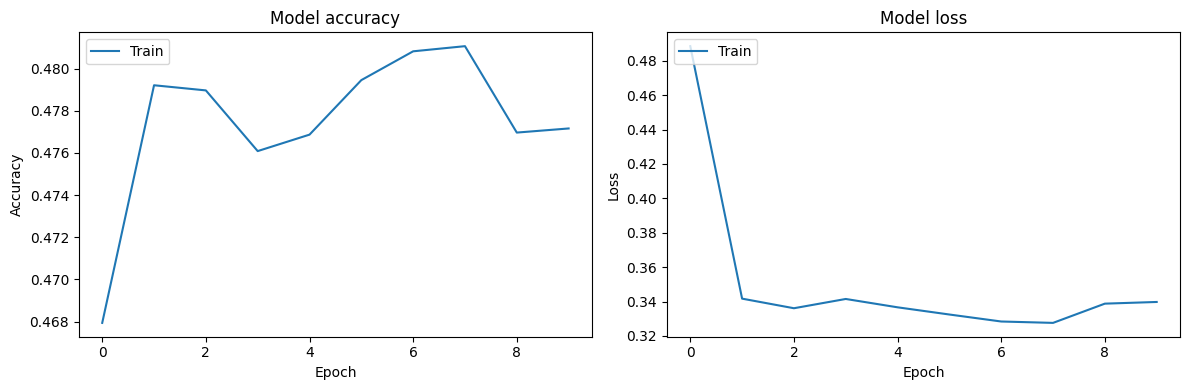

In [205]:
eval_loss, eval_accuracy = evaluate_model(model, dataset_te)
print(f"Eval loss: {eval_loss}, Eval accuracy: {eval_accuracy}")

# Plot the training history
plot_history(history)

# Testing retrieval performance

In [ ]:
list(all_bpmns.keys())

['sb_res_13bdebb53b584fbabd26a2e588c1547e.bpmn',
 'warenversand_-_english_e07e91f12a5741ed836579651fd0b38d.bpmn',
 'Aufgabe_1_38ebadc4d2744116ba565d266ebcc6af.bpmn',
 'Exercise_3_0d661bca636d43e79602b216cd8bc923.bpmn',
 'Claim_f339fddf3b1645a68a5c5745faf44e88.bpmn',
 'Neuer_Prozess_8_e667e365805046c9a1bf2ea764479fe5.bpmn',
 'Schufascoring_25040d9524894835b03b1ed68e87fe04.bpmn',
 'Neuer_Prozess_9e9fce4f6ccf4c8793cbb83dcf8beb69.bpmn',
 'warenversand_-_english_b8d95a804fb54510bafaae1fa10d3991.bpmn',
 'Ueb_1_5af419e60a25409697d7f768c7ce166c.bpmn',
 '-__bung_3_aa020f86ca734ca78c9e1dfb8c92b088.bpmn',
 'Restaurant_39ed618a5da04516af2ea39466dab4b2.bpmn',
 'Ueb_1_ae84ec3090aa4980a8dac59e4d557b47.bpmn',
 'Exercise3_Regress_41a37ed15e824f5dafac82ffd71ea1de.bpmn',
 'Versandbeauftragung_4e5073f5431f4e64b62f37df29306ffa.bpmn',
 '-_Schufa_9831eb834a924b9f9c4591000c9387ef.bpmn',
 'scoring_20b470b2f0c44dedaf1cb2f7c5924280.bpmn',
 'Excercise_3_-_Subrogation_995343cb589c438e9e0edd816860d54f.bpmn',
 'regr

In [ ]:
import numpy as np

def generate_inputs(bpmn_graph):
    """
    Generates the inputs for the embedding model from a BPMN graph.

    Parameters:
    bpmn_graph (dict): The BPMN graph.

    Returns:
    tuple: The node features and adjacency matrix of the BPMN graph.
    """
    # Create processor
    bpmn_processor = BPMNGraphProcessor()

    x = bpmn_processor.get_node_features(bpmn_graph)
    x = np.expand_dims(x, axis=0)  # Expands the dimensions to (1, N, F)

    a = bpmn_processor.get_adjacency_matrix(bpmn_graph)
    a = np.expand_dims(a.toarray(), axis=0)  # Expands the dimensions to (1, N, N)

    return x, a

def generate_embeddings(bpmn_graph, embedding_model):
    """
    Generates the embedding of a BPMN graph using a given model.

    Parameters:
    bpmn_graph (dict): The BPMN graph.
    embedding_model (Model): The model to use for generating the embedding.

    Returns:
    np.array: The embedding of the BPMN graph.
    """
    x, a = generate_inputs(bpmn_graph)
    embedding = embedding_model.predict([x, a], verbose=0)
    return embedding

def measure_similarity(graph1, graph2, prediction_model):
    """
    Measures the similarity between two BPMN graphs based on their embeddings.

    Parameters:
    graph1, graph2 (dict): The BPMN graphs to compare.
    embedding_model (Model): The model to use for generating the embeddings.

    Returns:
    float: The cosine similarity between the embeddings of the two graphs.
    """
    a_X, a_A = generate_inputs(graph1)
    b_X, b_A = generate_inputs(graph2)

    # Generate the predictions
    prediction = prediction_model.predict([a_X, a_A, b_X, b_A], verbose=0)

    return prediction[0][0]

from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar_graphs(graph, all_graphs, embedding_model, n=5):
    """
    Finds the top-n most similar graphs to a given graph based on their embeddings.

    Parameters:
    graph (dict): The given graph.
    all_graphs (dict): All available graphs.
    embedding_model (Model): The model to use for computing the embeddings.
    n (int): The number of most similar graphs to return.

    Returns:
    list: The top-n most similar graphs and their similarities.
    """
    # Compute the embedding of the given graph
    graph_embedding = embed_bpmn(graph, embedding_model)[0]

    similarities = []

    # Compute the cosine similarity with each other graph
    for other_graph in tqdm(all_graphs.values()):
        other_embedding = embed_bpmn(other_graph, embedding_model)[0]
        similarity = cosine_similarity(graph_embedding.reshape(1, -1), other_embedding.reshape(1, -1))
        similarities.append((other_graph, similarity))

    # Sort the graphs by similarity in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Return the top-n most similar graphs
    return similarities[:n]   

def find_most_similar_graphs_predictive(graph, all_graphs, prediction_model, n=5):
    """
    Finds the top-n most similar graphs to a given graph based on their embeddings.

    Parameters:
    graph (dict): The given graph.
    all_graphs (dict): All available graphs.
    prediction_model (Model): The model to use for computing the embeddings.
    n (int): The number of most similar graphs to return.

    Returns:
    list: The top-n most similar graphs and their similarities.
    """
    # Compute the embedding of the given graph
    graph_inputs = generate_inputs(graph)

    similarities = []

    # Compute the cosine similarity with each other graph
    for other_graph in tqdm(all_graphs.values()):
        other_inputs = generate_inputs(other_graph)
        prediction = prediction_model.predict([*graph_inputs, *other_inputs], verbose=0)[0][0]

        similarities.append((other_graph, prediction))

    # Sort the graphs by similarity in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Return the top-n most similar graphs
    return similarities[:n]

# Get a random BPMN graph
bpmn_graph = all_bpmns['Warenversand_e74e4fbcba1a48d3a4283a2e5bea3a2f.bpmn']

# Predict the class
embedding = generate_embeddings(bpmn_graph, embedding_model)[0]
print(f"Embedding: {embedding[:10]}")
print(f"Original embedding: {bpmn_graph.get_graph().get('embedding')[:10]}")

from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(embedding.reshape(1, -1), bpmn_graph.get_graph().get("embedding").reshape(1, -1))
print(f"Similarity: {sim}")

Embedding: [8.7794151e+00 7.6290250e-01 7.5755783e+01 7.0006310e+01 8.3404996e-02
 6.9792652e+00 7.9763107e+01 4.9141174e+01 8.6300049e+01 8.1024742e+01]
Original embedding: [ 0.02272176 -0.04879468 -0.01840889 -0.0084742   0.05015309 -0.08949476
  0.18099     0.09640867 -0.13617192  0.0034371 ]
Similarity: [[-0.01935622]]


In [ ]:
bpmn_graph = all_bpmns[list(all_bpmns.keys())[5]]
matches = find_most_similar_graphs_predictive(bpmn_graph, all_bpmns, model, n=5)

print("-----------------Matching:")
print("Query: ", bpmn_graph.file_path)
print("-----------------Results:")
for match in matches:
    print(match[1], match[0].file_path)

bpmn_graph.draw_graph()
for match in matches:
    print(match[1], match[0].file_path)
    match[0].draw_graph()

In [ ]:
# Get a random BPMN graph
bpmn_graph = all_bpmns['Warenversand_e74e4fbcba1a48d3a4283a2e5bea3a2f.bpmn']

# Find the 5 most similar graphs
most_similar_graphs = find_most_similar_graphs(bpmn_graph, all_bpmns, embedding_model, n=100)

for graph, similarity in most_similar_graphs:
    print(f"Similarity: {similarity}", f"Graph: {graph.file_path}")
    # print or do something with the similar graph

for graph, similarity in most_similar_graphs:
    print(f"Similarity: {similarity}",f"Graph: {graph.file_path}")
    graph.draw_graph()

100%|██████████| 597/597 [00:43<00:00, 13.86it/s]

Similarity: [[1.]] Graph: data\camunda\English\01-Dispatch-of-goods\02-Results\Warenversand_e74e4fbcba1a48d3a4283a2e5bea3a2f.bpmn
Similarity: [[0.9038068]] Graph: data\camunda\English\01-Dispatch-of-goods\02-Results\excercise_1_a55ce1fcd0964142b053ec217b5b81df.bpmn
Similarity: [[0.901696]] Graph: data\camunda\English\01-Dispatch-of-goods\02-Results\excersise_no1_525ba14ce6564d30868a15be6b485914.bpmn
Similarity: [[0.9015858]] Graph: data\camunda\English\01-Dispatch-of-goods\02-Results\excersise_no1_6e8c0acfcb0740d7bc60580f0d64a6bb.bpmn
Similarity: [[0.8912006]] Graph: data\camunda\English\01-Dispatch-of-goods\02-Results\Dispatch_1cb656bdb9ec435fbe33bf4df633c2f5.bpmn
Similarity: [[0.8687104]] Graph: data\camunda\English\01-Dispatch-of-goods\02-Results\Exercise_1_Dispatch_of_Goods_1b80d86d36ee4cf79bcd427aebdd943d.bpmn
Similarity: [[0.86162627]] Graph: data\camunda\English\01-Dispatch-of-goods\02-Results\Warenversand_b6183314a40a4041b05ac542cc468ac5.bpmn
Similarity: [[0.86141133]] Graph: d

# testing performance of the model in terms of accuracy, recall, precision and F1

In [30]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics.pairwise import cosine_similarity

similarity_threshold = 0.5
similarity_threshold_baseline = 0.5

# Separate positive and negative samples
positive_samples = [sample for sample in samples if sample["score"] > similarity_threshold]
negative_samples = [sample for sample in samples if sample["score"] <= similarity_threshold]

# Balance the samples
if len(positive_samples) > len(negative_samples):
    # Undersample the positive samples
    positive_samples = resample(positive_samples, replace=False, n_samples=len(negative_samples), random_state=42)
else:
    # Oversample the negative samples
    negative_samples = resample(negative_samples, replace=True, n_samples=len(positive_samples), random_state=42)

# Combine the balanced samples
balanced_samples = positive_samples[:200] + negative_samples[:200]

TP = FP = TN = FN = 0

samples_with_scores_and_diffs = []

from tqdm import tqdm

# Initialize the cache
embedding_cache = {}

for sample in tqdm(balanced_samples):

    # Get the embeddings from the cache if available, otherwise compute them
    query_embedding = embedding_cache.get(sample["query"])
    if query_embedding is None:
        query_embedding = generate_embeddings(sample["query"], embedding_model)[0]
        embedding_cache[sample["query"]] = query_embedding

    target_embedding = embedding_cache.get(sample["target"])
    if target_embedding is None:
        target_embedding = generate_embeddings(sample["target"], embedding_model)[0]
        embedding_cache[sample["target"]] = target_embedding

    # calculate the cosine similarity between the two embeddings and threshold it if both are not None
    if query_embedding is not None and target_embedding is not None:
        similarity = cosine_similarity(query_embedding.reshape(1, -1), target_embedding.reshape(1, -1))[0][0]
        prediction = similarity > similarity_threshold_baseline
        actual =  sample["score"] > similarity_threshold

        #print("actual: ", sample["score"], "prediction: ", similarity, "diff: ", abs(similarity - sample["score"]))

        # Calculate the difference between the score and the actual value
        diff = abs(similarity - actual)

        # Add the sample, similarity score, and difference to the list
        samples_with_scores_and_diffs.append((sample, similarity, diff))
        
        if prediction and actual:
            TP += 1
        elif prediction and not actual:
            FP += 1
        elif not prediction and actual:
            FN += 1
        else:
            TN += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * precision * recall / (precision + recall)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

# Calculate the number of positive and negative samples
positive_samples = TP + FN
negative_samples = TN + FP

# Calculate the ratio of positive to negative samples
positive_negative_ratio = positive_samples / negative_samples

print("Positive samples: ", positive_samples)
print("Negative samples: ", negative_samples)
print("Ratio of positive to negative samples: ", positive_negative_ratio)

# Calculate the total number of samples
total_samples = positive_samples + negative_samples

# Calculate the percentage of positive and negative samples
positive_percentage = (positive_samples / total_samples) * 100
negative_percentage = (negative_samples / total_samples) * 100

print("Positive samples: {:.2f}%".format(positive_percentage))
print("Negative samples: {:.2f}%".format(negative_percentage))

# Sort the list by the absolute difference, in descending order
samples_with_scores_and_diffs.sort(key=lambda x: x[2], reverse=True)

100%|██████████| 400/400 [00:00<00:00, 5118.81it/s]

Precision:  0.74542
Recall:  0.775
F1 Score:  0.7599222583233579
Positive samples:  200
Negative samples:  200
Ratio of positive to negative samples:  1.0
Positive samples: 50.00%
Negative samples: 50.00%


In [ ]:

import os
import numpy as np
from  spektral.data import Graph 
# Processing all BPMN files and storing the embeddings

def generate_bpmn_embeddings(bpmn_graphs, embedding_model):
    """
    Generates embeddings for each BPMN file using the provided embedding model.

    Parameters:
    bpmn_graphs (dict of BPMNGraphs): A dictionary mapping file paths to BPMN graphs.
    embedding_model (Model): The Keras model to use for generating the embeddings.

    Returns:
    dict: A dictionary mapping file paths to their corresponding embeddings.
    """
    # Initialize the dictionary to store the embeddings
    embeddings = {}
    bpmn_processor = BPMNGraphProcessor()

    # Iterate over all the BPMN files
    for file, bpmn_graph in bpmn_graphs.items():
        try:
            # Convert the BPMN file into a graph
            x = bpmn_processor.get_node_features(bpmn_graph)
            x = np.expand_dims(x, axis=0)  # Expands the dimensions to (1, N, F)

            a = bpmn_processor.get_adjacency_matrix(bpmn_graph)
            a = np.expand_dims(a.toarray(), axis=0)  # Expands the dimensions to (1, N, N)

            # Generate the embedding
            embedding = embedding_model.predict([x, a], verbose=0)

            # Store the embedding
            embeddings[file] = embedding[0]
            
        except Exception as e:
            print(f"An error occurred during the processing of the BPMN file: {e}")
            continue

    return embeddings

embeddings = generate_bpmn_embeddings(all_bpmns, embedding_model)

# embedding based version (dot product vs prediction header)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Dot, Lambda, Concatenate, Dense
import tensorflow.keras.backend as K
from spektral.layers import GCNConv, GlobalAvgPool, GlobalAttentionPool

def create_gcn_layers(embedding_dims):
    # Define the shared GCN layers
    graph_conv = GCNConv(embedding_dims, activation='relu', name='graph_conv')
    dropout = Dropout(0.2, name='dropout')
    graph_conv_2 = GCNConv(embedding_dims, activation='relu', name='graph_conv_2')
    dropout_2 = Dropout(0.2, name='dropout_2')
    graph_conv_3 = GCNConv(embedding_dims, activation='relu', name='graph_conv_3')
    global_pool = GlobalAttentionPool(embedding_dims,name='global_pool')
    #global_pool = GlobalAvgPool(name='global_pool')

    return graph_conv, dropout, graph_conv_2, dropout_2, graph_conv_3, global_pool

def create_graph_model(X_in, A_in, graph_layers):
    graph_conv, dropout, graph_conv_2, dropout_2, graph_conv_3, global_pool = graph_layers

    # Pass graph through the shared layers
    graph_conv_out = graph_conv([X_in, A_in])
    dropout_out = dropout(graph_conv_out)
    graph_conv_2_out = graph_conv_2([dropout_out, A_in])
    dropout_2_out = dropout_2(graph_conv_2_out)
    graph_conv_3_out = graph_conv_3([dropout_2_out, A_in])
    graph_embedding = global_pool(graph_conv_3_out)

    return graph_embedding

def create_models(n_features, embedding_dims):
    # Define the inputs for graph A
    A_X_in = Input(shape=(None, n_features), name='A_Node_features')
    A_A_in = Input((None, ), sparse=True, name='A_Adjacency_matrix')

    # Define the inputs for graph B
    B_X_in = Input(shape=(None, n_features), name='B_Node_features')
    B_A_in = Input((None, ), sparse=True, name='B_Adjacency_matrix')

    # Create the GCN layers
    graph_layers = create_gcn_layers(embedding_dims)

    # Create the graph embeddings
    A_graph_embedding = create_graph_model(A_X_in, A_A_in, graph_layers)
    B_graph_embedding = create_graph_model(B_X_in, B_A_in, graph_layers)


    # concatenate the two embeddings
    concatenated = Concatenate(name='concatenated')([A_graph_embedding, B_graph_embedding])
    dense_layer = Dense(64, activation='relu')(concatenated)
    dense_layer = Dropout(0.2, name='dropout_conc')(dense_layer)
    dense_output = Dense(1, activation='sigmoid', name='output')(dense_layer)


    # Perform dot product between the two graph embeddings
    dot_product = Dot(axes=1, normalize=True, name='dot_product')([A_graph_embedding, B_graph_embedding])
    
    # Create the main model
    model = Model(inputs=[A_X_in, A_A_in, B_X_in, B_A_in], outputs=dot_product, name='my_model')

    # Create the embedding model
    embedding_model = Model(inputs=[A_X_in, A_A_in], outputs=A_graph_embedding, name='embedding_model')

    return model, embedding_model

In [18]:
def train_model(model, dataset, batch_size=32, epochs=10):
    """
    Trains the model on the given dataset.

    Parameters:
    model (Model): The model to train.
    dataset (Dataset): The dataset to train the model on.
    batch_size (int): The batch size to use for training.
    epochs (int): The number of epochs to train the model for.

    Returns:
    History: A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs.
    """
    try:
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.metrics import Precision, Recall, AUC
        from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

        
        # Create the model
        model, embedding_model = create_models(n_features=384, embedding_dims=384)
        
        # Compile the model with additional metrics
        model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
        
        # Create a loader
        loader = BpmmComparingSpektralLoader(dataset, batch_size=batch_size, shuffle=True)

        # Log the shapes of the inputs and targets
        batch = next(loader.load())
        inputs, y = batch
        A_X, A_A, B_X, B_A = inputs
        
        print(f"A shape:( {A_X.shape}, {A_A.shape}), B shape:( {B_X.shape}, {B_A.shape}), y shape: {y.shape}")

        # Train the model
        history = model.fit(loader.load(), steps_per_epoch=loader.steps_per_epoch, epochs=epochs)

        return model, embedding_model, history
    except Exception as e:
        print(f"An error occurred: {e}")

    return None, None, None


# Train the model
model = create_models(n_features=384, embedding_dims=384)
model, embedding_model, history = train_model(model, dataset_tr, epochs = 10)

A shape:( (32, 40, 384), (32, 40, 40)), B shape:( (32, 40, 384), (32, 40, 40)), y shape: (32,)
Epoch 1/10


c:\Users\StefaanVercoutere\OneDrive - Sirus NV\OPH\gnn-citations\.conda\Lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'BPMNGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1211/1211 [==============================] - 109s 89ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - mean_absolute_error: 0.0683
Epoch 2/10
1211/1211 [==============================] - 118s 98ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - mean_absolute_error: 0.0454
Epoch 3/10
1211/1211 [==============================] - 129s 106ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - mean_absolute_error: 0.0397
Epoch 4/10
1211/1211 [==============================] - 127s 105ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - mean_absolute_error: 0.0360
Epoch 5/10
1211/1211 [==============================] - 122s 101ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - mean_absolute_error: 0.0337
Epoch 6/10
1211/1211 [==============================] - 125s 103ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0317
Epoch 7/10
1211/1211 [==============================] - 130s 107ms/step - loss: 0.0015 - root_mean_squared_

Eval loss: 0.002406938700005412, Eval mse: 0.04906056076288223, Eval mae: 0.03292493149638176
Available metrics: dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error'])


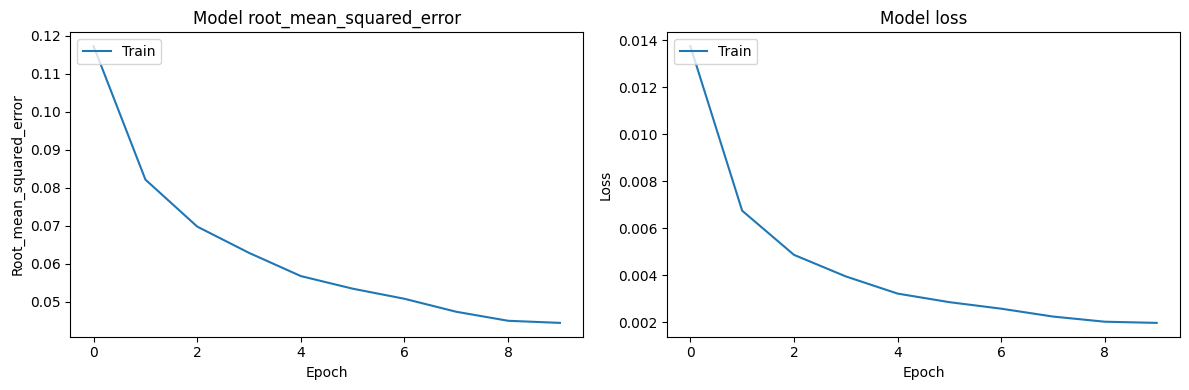

In [254]:
loss, mse, mae = evaluate_model(model, dataset_te)
print(f"Eval loss: {loss}, Eval mse: {mse}, Eval mae: {mae}")

# Available metrics
print(f"Available metrics: {history.history.keys()}")

# Plot the training history
plot_history(history, 'root_mean_squared_error')